Using a 2D nvmpy grid, we'll approximate the continous space of navier stokes. Assuming a uniform cartesian grid, with uniform grid spacing "h".<br><br>

For each position in the field, we need to store the following <br>
- Velocity components in x and y directions : u[i,j], v[i,j]
- Pressure at each point : p[i,j]

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
plt.ion()

In [26]:
#Domeneparameter:
Lx      = 1.0       #Length in x-direction
Ly      = 1.0
Nx, Ny  = 41, 41    #Number of grid points
h       = Lx / (Nx - 1)


#Lagrer X og Y koordinatarray:
x       = np.linspace(0, Lx, Nx)
y       = np.linspace(0, Ly, Ny)


#Fluidparameter:
nu      = 1e-6 #Kinematisk viskositet
rho     = 1000
g       = 9.81e2


#Tidsparameter:
dt      = 0.01
t_end   = 20.0
n_steps = int(t_end / dt)


#Initialiserer hastighetsfelt:
u       = np.zeros((Ny, Nx))        #NB! Hugs at i er langs y retninga
v       = np.zeros((Ny, Nx))

#Simuleringsparameter:
contour = False

def add_starting_noise():
    global u,v
    u += np.random.uniform(-0.1,0.1, size=(Ny,Nx))  #Add noise to u
    v += np.random.uniform(-0.1,0.1, size=(Ny,Nx))  

In [27]:
#Implementere time stepping for diskrete verdier:

def calculate_viscous_term_u(u, nu, h, i, j):
    """Summary:    
    Args:
    u (numpy.ndarray): 2D array of v-velocity values (shape: (Ny, Nx)).
    nu (float): Kinematic viscosity.
    h (float): Grid spacing.
    i (int): x-index of the grid point.
    j (int): y-index of the grid point.

    Returns:
    float: Viscous term value for v-component at (i, j).
    """
    
    return nu * ( (u[j, i+1] + u[j, i-1] - 2*u[j, i]) / h**2  +  (u[j+1, i] + u[j-1, i] - 2*u[j, i]) / h**2 )


def calculate_viscous_term_v(v, nu, h, i, j):
    """Summary:    
    Args:
    v (numpy.ndarray): 2D array of v-velocity values (shape: (Ny, Nx)).
    nu (float): Kinematic viscosity.
    h (float): Grid spacing.
    i (int): x-index of the grid point.
    j (int): y-index of the grid point.

    Returns:
    float: Viscous term value for v-component at (i, j).
    """
    return nu * ( (v[j+1, i] + v[j-1, i] - 2*v[j, i]) / h**2  +  (v[j, i+1] + v[j, i-1] - 2*v[j, i]) / h**2 )

#Used in part of the momentum equation, i.e solving for time
def calculate_convective_term_u(u, v, h, i, j):
    return -(u[j,i])*(u[j,i+1] - u[j,i-1])/(2*h) + (v[j,i])*(u[j+1,i] - u[j-1,i])/(2*h)

def calculate_convective_term_v(u, v, h, i, j):
    return -(u[j,i])*(v[j,i+1] - v[j,i-1])/(2*h) + (v[j,i])*(v[j+1,i] - v[j-1,i])/(2*h)

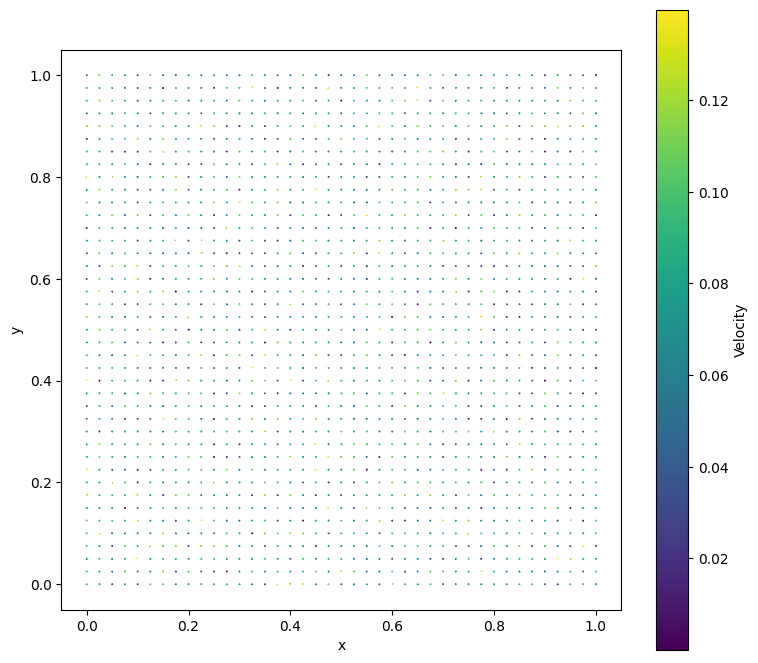

KeyboardInterrupt: 

In [28]:
def update_velocities():
    global u,v
    u_new = np.zeros((Ny,Nx))
    v_new = np.zeros((Ny,Nx))
    
    
    
    #Iterating through all values:
    for i in range(1,Nx-1):
        for j in range(1, Ny-1):
            
            #DEBUG:
            #print(calculate_viscous_term_u(u,nu,h,i,j), calculate_viscous_term_v(v,nu,h,i,j), calculate_convective_term_u(u,v,h,i,j),calculate_convective_term_v(u,v,h,i,j) )
            
            u_new[j,i] = (calculate_viscous_term_u(u,nu,h,i,j) + calculate_convective_term_u(u,v,h,i,j)) * (1/rho) * (dt) + u[j,i]
            v_new[j,i] = (calculate_viscous_term_v(v,nu,h,i,j) + calculate_convective_term_v(u,v,h,i,j) - g) * (1/rho) * (dt) + v[j,i]  #Gravity works in y direction
            
    #No-slip boundaries:
    u_new[:,0]      = 0
    u_new[:,Nx-1]   = 0
    u_new[0,:]      = 0
    u_new[Ny-1,:]   = 0
    
    v_new[:,0]      = 0
    v_new[:,Nx-1]   = 0
    v_new[0,:]      = 0
    v_new[Ny-1,:]   = 0
    
    #Updating velocities:
    u = u_new
    v = v_new
    

def plot_velocity_field(fig, ax, cbar_ax=None):
    """Plot velocity field with proper colorbar management"""
    ax.clear()
    
    # Create new plot elements
    X_grid, Y_grid = np.meshgrid(x, y)
    velocity_magnitude = np.sqrt(u**2 + v**2)
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    # Create new quiver plot
    q = ax.quiver(X_grid, Y_grid, u, v, velocity_magnitude,
                 cmap="viridis",
                 linewidth=0.5,
                 edgecolors="face",
                 headaxislength=5,
                 headlength=6,
                 scale=50)
    
    ax.set_aspect("equal")
    
    # Create colorbar in the dedicated axes
    fig.colorbar(q, cax=cbar_ax, label="Velocity")
    
    if contour:
        contour_plot = ax.contourf(X_grid, Y_grid, velocity_magnitude)
    
    # Force immediate draw
    fig.canvas.draw()
    plt.pause(0.001)
    
    return cbar_ax



#Main time loop
def main():
    add_starting_noise()
    
    # Create figure and axes once
    plt.close('all')
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])  # [left, bottom, width, height]
    
    # Initialize colorbar
    cbar_ax = plot_velocity_field(fig, ax)
    
    for n in range(n_steps):
        update_velocities()
        
        if n % 10 == 0:
            cbar_ax = plot_velocity_field(fig, ax, cbar_ax)
    
    plt.ioff()
    plt.show()
    return

main()

Now we need to discretize the derivatives. This can be done using finite difference approximations - for this we will use the central difference approximation: <br> <br>

For example, for pressure this becomes: dell p / dell x = (P[i+1,j]- P[i-1,j])/2h.
<br><br>

Continuing, we need discretizations of the second order derivatives, laplacian operator and the convective term (see notes):  <br><br>

For Time, we use the forward difference (we will be stepping forwards in time)


    """    
    #Defining steps
    i_forward   = i + 1
    i_backward  = i - 1
    j_forward   = j + 1
    j_backward  = j - 1
    
    #Doing edge cases
    X_edge = j % (Nx-1) == 0
    Y_edge = i % (Ny-1) == 0

    if X_edge:
        if j == Ny-1:   j_forward   = 0
        else:           j_backward  = Ny-1
    if Y_edge: 
        if i == Nx-1:   i_forward   = 0
        else:           i_backward  = Nx-1"""